# Lagrangian particle demonstration in a regional MITgcm configuration without faces and with open boundaries.

### Wenrui Jiang, Tom Haine Feb '23

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import oceanspy as ospy

### The regional MITgcm run is the IGPwinter simulation, available on SciServer. The simulation is opened using the OceanSpy package.

### See: https://oceanspy.readthedocs.io/en/latest/datasets.html#igpwinter and https://dev-poseidon-ocean.pantheonsite.io/products/datasets/.

In [2]:
od = ospy.open_oceandataset.from_catalog('IGPwinter')

Opening IGPwinter.
High-resolution numerical simulation carried out in parallel to the observational
component of the Iceland Greenland Seas Project (IGP).
Citation:
 * Renfrew et al., 2019 - BAMS.


### Artificially create an open boundary in depth.

In [3]:
ds = od._ds.isel(Z = slice(0,50),Zl = slice(0,50))
ds

<xarray.Dataset>
Dimensions:       (Z: 50, Zp1: 217, Zu: 216, Zl: 50, X: 960, Y: 880, Xp1: 961,
                   Yp1: 881, time: 360, time_midp: 359)
Coordinates: (12/18)
  * Z             (Z) float64 -1.0 -3.5 -7.0 -11.5 ... -749.5 -768.5 -787.5
  * Zp1           (Zp1) float64 0.0 -2.0 -5.0 ... -3.932e+03 -3.951e+03
  * Zu            (Zu) float64 -2.0 -5.0 -9.0 ... -3.932e+03 -3.951e+03
  * Zl            (Zl) float64 0.0 -2.0 -5.0 -9.0 ... -740.0 -759.0 -778.0
  * X             (X) float64 -45.0 -44.76 -44.52 -44.29 ... 23.52 23.76 24.0
  * Y             (Y) float64 57.0 57.08 57.17 57.25 ... 78.75 78.83 78.92 79.0
    ...            ...
  * time          (time) datetime64[ns] 2018-01-01 ... 2018-03-31T18:00:00
    YU            (Y, Xp1) float64 dask.array<chunksize=(880, 961), meta=np.ndarray>
    XU            (Y, Xp1) float64 dask.array<chunksize=(880, 961), meta=np.ndarray>
    YV            (Yp1, X) float64 dask.array<chunksize=(881, 960), meta=np.ndarray>
    XV            (Yp1, X) float64 dask.array<chunksize=(881, 960), meta=np.ndarray>
  * time_midp     (time_midp) datetime64[ns] 2018-01-01T03:00:00 ... 2018-03-...
Data variables: (12/102)
    drC           (Zp1) float64 dask.array<chunksize=(217,), meta=np.ndarray>
    drF           (Z) float64 dask.array<chunksize=(50,), meta=np.ndarray>
    dxC           (Y, Xp1) float64 dask.array<chunksize=(880, 961), meta=np.ndarray>
    dyC           (Yp1, X) float64 dask.array<chunksize=(881, 960), meta=np.ndarray>
    dxF           (Y, X) float64 dask.array<chunksize=(880, 960), meta=np.ndarray>
    dyF           (Y, X) float64 dask.array<chunksize=(880, 960), meta=np.ndarray>
    ...            ...
    SItflux       (time, Y, X) float64 dask.array<chunksize=(4, 880, 960), meta=np.ndarray>
    SIaaflux      (time, Y, X) float64 dask.array<chunksize=(4, 880, 960), meta=np.ndarray>
    SIhl          (time, Y, X) float64 dask.array<chunksize=(4, 880, 960), meta=np.ndarray>
    SIempmr       (time, Y, X) float64 dask.array<chunksize=(4, 880, 960), meta=np.ndarray>
    oceSPflx      (time, Y, X) float64 dask.array<chunksize=(4, 880, 960), meta=np.ndarray>
    oceSPDep      (time, Y, X) float64 dask.array<chunksize=(4, 880, 960), meta=np.ndarray>
Attributes: (12/23)
    MITgcm_version:        checkpoint67l
    build_user:            malmans2@jhu.edu
    build_host:            compute0673
    build_date:            Fri Nov  8 01:36:45 EST 2019
    MITgcm_URL:            http://mitgcm.org
    MITgcm_tag_id:         
    ...                    ...
    Nr:                    216
    OceanSpy_parameters:   {'rSphere': 6371.0, 'eq_state': 'mdjwf', 'rho0': 1...
    OceanSpy_name:         IGP
    OceanSpy_description:  High-resolution numerical simulation carried out i...
    OceanSpy_projection:   Mercator(**{})
    OceanSpy_grid_coords:  {'Y': {'Y': None, 'Yp1': 0.5}, 'X': {'X': None, 'X...

### Initialize OceInterp package.

In [4]:
import OceInterp as oi
oce = oi.OceData(ds)

no CS in dataset, skip
no SN in dataset, skip


### Initialize the particles: We put the ducks on the East Greenland continental shelf...

In [5]:
Nx = 20
Nz = 10
x = np.linspace(-22,-20,Nx)
z = np.linspace(0,-200,Nz)
x,z = np.meshgrid(x,z)
x = x.ravel()
z = z.ravel()
y = np.ones_like(x)*71.

### ...and at the beginning of the simulation...

In [6]:
start_time = '2018-01-02'
t = (np.array([np.datetime64(start_time) for i in x])
     -np.datetime64('1970-01-01'))/np.timedelta64(1, 's')

### ...and integrate forward in time for one month.

In [7]:
tf = (np.datetime64('2018-02-01')
     -np.datetime64('1970-01-01'))/np.timedelta64(1, 's')

### Here is where the particles start on the map:

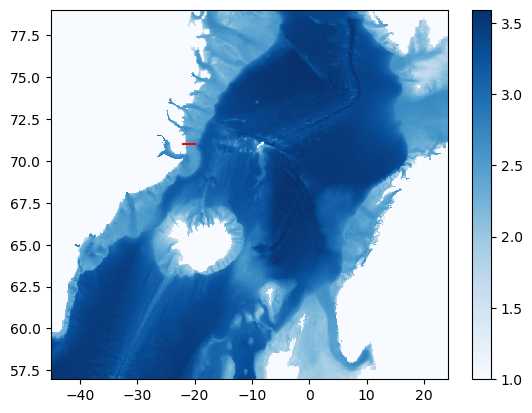

In [8]:
plt.pcolormesh(od._ds['XC'],od._ds['YC'],np.log10(od._ds['Depth']+10),cmap = 'Blues')
plt.plot(x,y,'r')
plt.colorbar()

### Define a function to control when to continue simulation, or to stop it. The simulation will only continue for particles that return True.

#### This function filters particles based on their geographic position.

In [9]:
def continue_criterion(pt):
    x_ = np.logical_and(pt.lon<0,pt.lon>-43)
    y_ = np.logical_and(pt.lat<77.5,pt.lat>57.5)
    z_ = pt.dep>-750
    return np.logical_and(np.logical_and(x_,y_),z_)

### Use volume flux (transport) to advect the particles. This is usually better than using the velocity field itself.

In [10]:
oce['utrans'] = oce['U']*oce['drF']*oce['dyG']
oce['vtrans'] = oce['V']*oce['drF']*oce['dxG']
oce['wtrans'] = oce['W']*oce['rA']

### Create the particle object. 

In [11]:
p = oi.particle(x = x,y=y,z=z,t=t,
                data = oce,
                continue_criterion = continue_criterion,
                uname = 'utrans',
                vname = 'vtrans',
                wname = 'wtrans',
                # save_raw = True,
                transport = True,
                )

### Perform the particle trajectory simulation.

In [12]:
stops,raw = p.to_list_of_time([t[0],tf])

/home/idies/workspace/Temporary/Thomas.Haine/scratch/Poseidon_testing/treon_notebook_testing/ci-2023-03-30-15-55-10-lf9/OceInterp/OceInterp/get_masks.py:108: UserWarning: no maskC in the dataset, assuming nothing is masked.
  warnings.warn('no maskC in the dataset, assuming nothing is masked.')
/home/idies/workspace/Temporary/Thomas.Haine/scratch/Poseidon_testing/treon_notebook_testing/ci-2023-03-30-15-55-10-lf9/OceInterp/OceInterp/get_masks.py:108: UserWarning: no maskC in the dataset, assuming nothing is masked.
  warnings.warn('no maskC in the dataset, assuming nothing is masked.')
/home/idies/workspace/Temporary/Thomas.Haine/scratch/Poseidon_testing/treon_notebook_testing/ci-2023-03-30-15-55-10-lf9/OceInterp/OceInterp/get_masks.py:108: UserWarning: no maskC in the dataset, assuming nothing is masked.
  warnings.warn('no maskC in the dataset, assuming nothing is masked.')
/home/idies/workspace/Temporary/Thomas.Haine/scratch/Poseidon_testing/treon_notebook_testing/ci-2023-03-30-15-55


2018-01-02T00:00:00
0 left 

/home/idies/workspace/Temporary/Thomas.Haine/scratch/Poseidon_testing/treon_notebook_testing/ci-2023-03-30-15-55-10-lf9/OceInterp/OceInterp/get_masks.py:108: UserWarning: no maskC in the dataset, assuming nothing is masked.
  warnings.warn('no maskC in the dataset, assuming nothing is masked.')



2018-01-02T03:00:00
200 left 95 left 9 left 

/home/idies/workspace/Temporary/Thomas.Haine/scratch/Poseidon_testing/treon_notebook_testing/ci-2023-03-30-15-55-10-lf9/OceInterp/OceInterp/get_masks.py:108: UserWarning: no maskC in the dataset, assuming nothing is masked.
  warnings.warn('no maskC in the dataset, assuming nothing is masked.')



2018-01-02T09:00:00
200 left 73 left 24 left 4 left 
2018-01-02T15:00:00
200 left 80 left 22 left 3 left 
2018-01-02T21:00:00
200 left 82 left 23 left 5 left 
2018-01-03T03:00:00
200 left 88 left 26 left 10 left 3 left 
2018-01-03T09:00:00
200 left 92 left 30 left 10 left 3 left 
2018-01-03T15:00:00
200 left 98 left 40 left 8 left 2 left 
2018-01-03T21:00:00
200 left 85 left 28 left 10 left 3 left 
2018-01-04T03:00:00
200 left 80 left 23 left 11 left 1 left 1 left 
2018-01-04T09:00:00
200 left 93 left 29 left 10 left 6 left 1 left 
2018-01-04T15:00:00
200 left 87 left 35 left 11 left 1 left 
2018-01-04T21:00:00
200 left 85 left 30 left 10 left 1 left 
2018-01-05T03:00:00
200 left 94 left 34 left 9 left 1 left 
2018-01-05T09:00:00
200 left 91 left 32 left 10 left 2 left 
2018-01-05T15:00:00
200 left 89 left 37 left 9 left 2 left 
2018-01-05T21:00:00
200 left 98 left 33 left 13 left 3 left 2 left 
2018-01-06T03:00:00
200 left 102 left 45 left 14 left 4 left 
2018-01-06T09:00:00
200 left

### Retrieve the particle positions from the `oi.eulerian.position` objects.

In [13]:
lons = np.array([pt.lon for pt in raw])
lats = np.array([pt.lat for pt in raw])

### Plot results.

(65.0, 72.0)

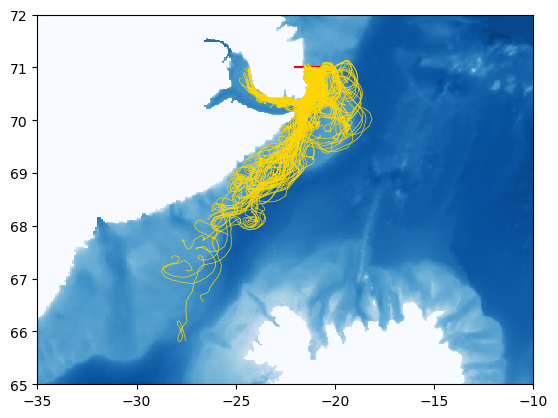

In [14]:
plt.pcolormesh(od._ds['XC'],od._ds['YC'],np.log10(od._ds['Depth']+10),cmap = 'Blues')
plt.plot(x,y,'r')
plt.plot(lons,lats,'gold',lw = 0.5)
plt.xlim([-35,-10])
plt.ylim([65,72])